# Log Linear

## Description

The log-linear dose response model fits a piecewise linear model to $E$ VS $\log(d)$. Because this model makes no specific assumption about the shape of the response data, it can be used when other models lead to poor fits.

It has no parameters.

The log-linear model has a few quirks that users should be aware of

- Once a model has been fit to data with doses ranging from `dmin` to `dmax`, `model.E(d)` will be `np.nan` for all `d < dmin` and all `d > dmax`.
- If `d=0` is one of the doses included in the fitting data, then that dose is replaced with `np.nextafter(0, 1)`, which is the smallest positive float value. This allows for log-scaling without running into infinities.
  - This behavior can be avoided by either
    - excluding `d==0` from your fitting dataset, or
    - replacing `d==0` values with your own chosen "zero" value. One useful utility for this is `synergy.utils.dose_utils.remove_zeros()` which looks at the ratios between non-zero doses to determine reasonable values to substitute for `0`s.

`synergy.single.LogLinear` supports two modes

- `nan_inverses = False` (default)
  - For ranges of $E$ that do not map to a unique value of $d$, `model.E_inv(E)` will fit a single log-linear segment for the entire range (see below)
- `nan_inverses = True`
  - For ranges of $E$ that do not map to a unique value of $d$, `model.E_inv(E)` will return `np.nan`

## Assumptions

- None

## Sigmoidal Example

### Fit the model to data

Dose response models work with 1D arrays of E and drug dose.

In [1]:
from synergy.datasets import load_hill_example
from synergy.single import LogLinear

d, E = load_hill_example()
model = LogLinear()
model.fit(d, E)

### Plot the model fit

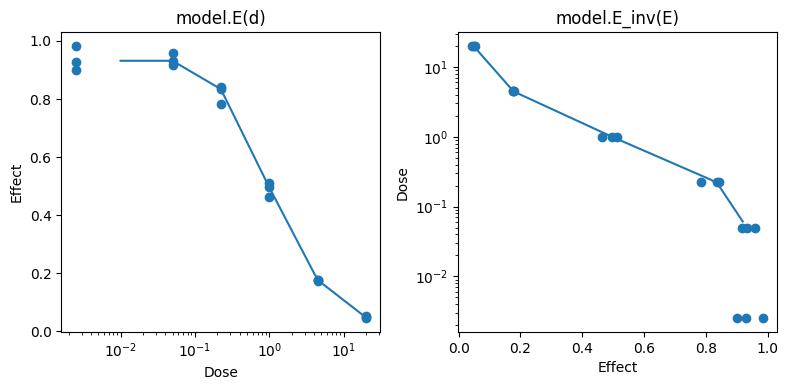

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from synergy.utils.base import remove_zeros

# These are used as the x-axis values for model.E(d) and model.E_inv(E), respectively
d_smooth = np.logspace(-2, 2)
E_smooth = np.linspace(0, 1)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
# Plot raw data
ax.scatter(remove_zeros(d, num_dilutions=2), E)  # remove_zeros() helps include d=0 on log(d) plots
# Plot model fit
ax.plot(d_smooth, model.E(d_smooth))
ax.set_xscale("log")
ax.set_xlabel("Dose")
ax.set_ylabel("Effect")
ax.set_title("model.E(d)")

ax = fig.add_subplot(1, 2, 2)
ax.scatter(E, remove_zeros(d, num_dilutions=2))
ax.plot(E_smooth, model.E_inv(E_smooth))
ax.set_yscale("log")
ax.set_xlabel("Effect")
ax.set_ylabel("Dose")
ax.set_title("model.E_inv(E)")

plt.tight_layout()
plt.show()

## Non-sigmoidal Example

The strength of the `LogLinear` model is that it can be used even when drug response data behaves in non-sigmoidal ways. To deomonstrate this, we will fit a model to a new synthetic dataset.

### Fit the model to data

In [3]:
d = np.logspace(-2, 2, num=10)
E = np.asarray([1, 0.9, 0.8, 0.85, 0.7, 0.5, 0.4, 0.6, 0.3, 0])

model = LogLinear()
model.fit(d, E)

### Plot the model fit

Because of the shape of this dose-response curve, we are specifically highlighting the regions that impacted by the `nan_inverses=False` mode. We also plot the transpose of `model.E(d)` to clearly show how those uninvertible regions do not have a well-defined inverse.

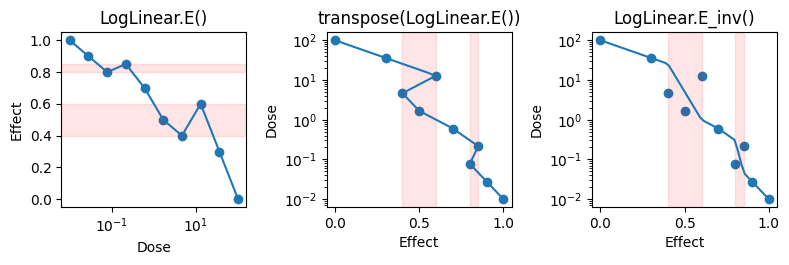

In [4]:
# This is generally not needed, but for this demo it is useful to precompute
# the uninvertible_domains to be highlighted.
model._prepare_inverse()

# These are used as the x-axis values for model.E(d) and model.E_inv(E), respectively
d_smooth = np.logspace(-2, 2)
E_smooth = np.linspace(0, 1)

fig = plt.figure(figsize=(8, 2.75))

# Plot the model.E(d) vs d, highlighting uninvertible domains
ax = fig.add_subplot(1, 3, 1)
ax.scatter(remove_zeros(d, num_dilutions=2), E)
ax.plot(d_smooth, model.E(d_smooth))
ax.set_xscale("log")
xlim = ax.get_xlim()
for region in model._uninvertible_domains:
    ax.fill_between(xlim, region[0], region[1], color="r", alpha=0.1)
ax.set_xlim(xlim)
ax.set_xlabel("Dose")
ax.set_ylabel("Effect")
ax.set_title("LogLinear.E()")

# Plot the transpose of model.E(d) vs d, highlighting uninvertible domains.
# The transpose is the inverse, but clearly shows that there is not a 1-1
# correspondence between E -> dose in certain domains
ax = fig.add_subplot(1, 3, 2)
ax.scatter(E, remove_zeros(d, num_dilutions=2))
ax.plot(model.E(d_smooth), d_smooth)
ax.set_yscale("log")
ylim = ax.get_ylim()
for region in model._uninvertible_domains:
    ax.fill_between(region, ylim[0], ylim[1], color="r", alpha=0.1)
ax.set_ylim(ylim)
ax.set_xlabel("Effect")
ax.set_ylabel("Dose")
ax.set_title("transpose(LogLinear.E())")

# Plot model.E_inv(E) vs E, showing how the LogLinear model handles
# uninvertible domains when nan_inverses=False
ax = fig.add_subplot(1, 3, 3)
ax.scatter(E, remove_zeros(d, num_dilutions=2))
ax.plot(E_smooth, model.E_inv(E_smooth))
ax.set_yscale("log")
ylim = ax.get_ylim()
for region in model._uninvertible_domains:
    ax.fill_between(region, ylim[0], ylim[1], color="r", alpha=0.1)
ax.set_ylim(ylim)
ax.set_xlabel("Effect")
ax.set_ylabel("Dose")
ax.set_title("LogLinear.E_inv()")

plt.tight_layout()
plt.show()

### Fit data to `nan_inverses=True` model

Here we show how `LogLinear.E_inv()` works when `nan_inverses=True`, compared to the above when `nan_inverses=False`.

In [5]:
model_nan = LogLinear(nan_inverses=True)
model_nan.fit(d, E)

### Plot the `nan_inverses=True` model fit

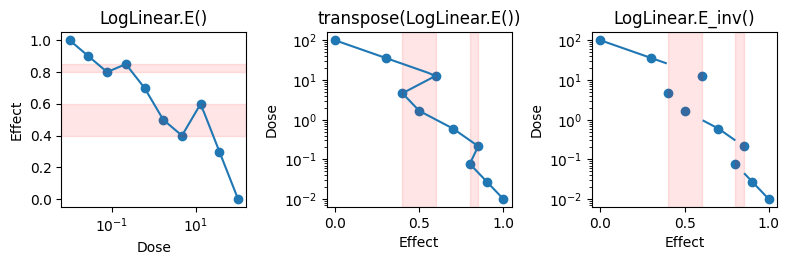

In [6]:
# This is generally not needed, but for this demo it is useful to precompute
# the uninvertible_domains to be highlighted.
model_nan._prepare_inverse()

# These are used as the x-axis values for model.E(d) and model.E_inv(E), respectively
d_smooth = np.logspace(-2, 2)
E_smooth = np.linspace(0, 1)

fig = plt.figure(figsize=(8, 2.75))

# Plot the model.E(d) vs d, highlighting uninvertible domains
ax = fig.add_subplot(1, 3, 1)
ax.scatter(remove_zeros(d, num_dilutions=2), E)
ax.plot(d_smooth, model_nan.E(d_smooth))
ax.set_xscale("log")
xlim = ax.get_xlim()
for region in model_nan._uninvertible_domains:
    ax.fill_between(xlim, region[0], region[1], color="r", alpha=0.1)
ax.set_xlim(xlim)
ax.set_xlabel("Dose")
ax.set_ylabel("Effect")
ax.set_title("LogLinear.E()")

# Plot the transpose of model.E(d) vs d, highlighting uninvertible domains.
# The transpose is the inverse, but clearly shows that there is not a 1-1
# correspondence between E -> dose in certain domains
ax = fig.add_subplot(1, 3, 2)
ax.scatter(E, remove_zeros(d, num_dilutions=2))
ax.plot(model_nan.E(d_smooth), d_smooth)
ax.set_yscale("log")
ylim = ax.get_ylim()
for region in model_nan._uninvertible_domains:
    ax.fill_between(region, ylim[0], ylim[1], color="r", alpha=0.1)
ax.set_ylim(ylim)
ax.set_xlabel("Effect")
ax.set_ylabel("Dose")
ax.set_title("transpose(LogLinear.E())")

# Plot model.E_inv(E) vs E, showing how the LogLinear model handles
# uninvertible domains when nan_inverses=True
ax = fig.add_subplot(1, 3, 3)
ax.scatter(E, remove_zeros(d, num_dilutions=2))
ax.plot(E_smooth, model_nan.E_inv(E_smooth))
ax.set_yscale("log")
ylim = ax.get_ylim()
for region in model_nan._uninvertible_domains:
    ax.fill_between(region, ylim[0], ylim[1], color="r", alpha=0.1)
ax.set_ylim(ylim)
ax.set_xlabel("Effect")
ax.set_ylabel("Dose")
ax.set_title("LogLinear.E_inv()")

plt.tight_layout()
plt.show()